### Cleanup Algorithm Area Output

Here I take the best index generated by the algorithm, reassign the club numbers and locations, assign areas, and plot the result.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
import random

import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from grouping_functions import select_grouping_function
from assignment_functions import select_assignment_function

In [2]:
best_index = [47, 20, 112, 19, 161, 134, 115, 85, 88, 45, 63, 126, 83, 16, 61, 142, 38, 154, 158, 39, 100, 101, 65, 145, 160, 111, 90, 165, 40, 105, 72, 69, 167, 26, 135, 15, 64, 137, 10, 117, 106, 18, 129, 144, 3, 103, 152, 151, 81, 109, 7, 23, 148, 102, 30, 141, 114, 150, 166, 139, 66, 22, 80, 28, 75, 51, 55, 82, 34, 153, 44, 157, 146, 99, 42, 92, 86, 32, 5, 37, 97, 140, 119, 59, 73, 78, 159, 25, 93, 74, 156, 9, 91, 29, 131, 113, 14, 46, 62, 33, 162, 50, 21, 49, 98, 4, 57, 1, 127, 12, 122, 8, 54, 95, 11, 94, 132, 76, 79, 143, 128, 110, 163, 89, 35, 123, 120, 48, 147, 67, 53, 136, 84, 36, 155, 118, 58, 27, 41, 125, 104, 60, 133, 138, 52, 71, 121, 164, 0, 108, 96, 56, 124, 107, 116, 24, 13, 70, 31, 149, 87, 43, 2, 68, 130, 6, 17, 77]

In [3]:
grouping = select_grouping_function(len(best_index))

In [4]:
areas_best_index = list(grouping(best_index))

In [5]:
with open('../data/loc.pickle', 'rb') as f:  
    loc = pickle.load(f)

In [6]:
loc[:5]

[array([-96.8751  ,  32.661446], dtype=float32),
 array([-96.772194,  32.833096], dtype=float32),
 array([-93.74332,  32.5064 ], dtype=float32),
 array([-96.81191,  33.08443], dtype=float32),
 array([-96.74601 ,  32.877766], dtype=float32)]

In [7]:
best_df = pd.DataFrame(best_index, columns = ['club_index'])
best_df.head()

,club_index
0,47
1,20
2,112
3,19
4,161


### Assign areas to the indices

In [8]:
assign_areas = select_assignment_function(len(best_index))

In [9]:
assign_areas

<function assignment_functions.assign_areas_three_left(clubs)>

In [10]:
best_df['area'] = assign_areas(best_index)

In [11]:
best_df.head()

,club_index,area
0,47,1
1,20,1
2,112,1
3,19,1
4,161,1


### Make the club index the df index and sort

In [12]:
bdf = best_df.copy().set_index('club_index').sort_index()

In [13]:
bdf = bdf.reset_index(drop=True)

In [14]:
bdf.head()

,area
0,30
1,22
2,33
3,9
4,22


### Bring in the club numbers and locations

In [15]:
old_clubs = pd.read_csv('..\clubs.csv')

In [16]:
assert len(bdf) == len(old_clubs)

In [17]:
best_dist = old_clubs.join(bdf).sort_values(['area', 'club_no']).reset_index(drop=True)

In [18]:
best_dist.head()

,club_no,n_quality,lat,long,area
0,4108,0.619137,32.879149,-96.744115,1
1,4110,0.486465,32.880272,-96.745039,1
2,7533,0.648441,32.912718,-96.734120,1
3,2923054,0.472952,32.880281,-96.744544,1
4,7402713,0.700597,32.879856,-96.743530,1


### Export Clubs and Areas for Later

In [19]:
area_clubs = best_dist.drop('n_quality', axis=1)

In [20]:
area_clubs.head()

,club_no,lat,long,area
0,4108,32.879149,-96.744115,1
1,4110,32.880272,-96.745039,1
2,7533,32.912718,-96.734120,1
3,2923054,32.880281,-96.744544,1
4,7402713,32.879856,-96.743530,1


### Find Centroids for Areas

In [22]:
area_centroids = best_dist.drop(['club_no', 'n_quality'], axis=1).groupby('area').mean()

In [23]:
area_centroids.head()

,lat,long
area,,
1,32.886455,-96.742270
2,33.091980,-96.840816
3,32.988463,-96.739093
4,32.968693,-96.646721
5,32.864624,-96.297988


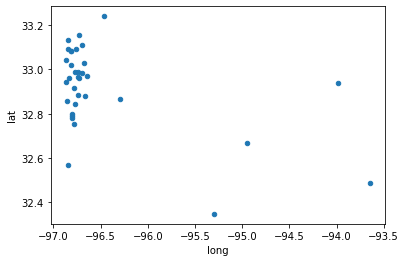

In [24]:
area_centroids.plot.scatter('long', 'lat');

In [25]:
g_area_centroids = gpd.GeoDataFrame(area_centroids,
                                    geometry=gpd.points_from_xy(
                                        area_centroids.long, area_centroids.lat),
                                    crs="EPSG:4326")

In [26]:
g_area_centroids.head()

,lat,long,geometry
area,,,
1,32.886455,-96.742270,POINT (-96.74227 32.88646)
2,33.091980,-96.840816,POINT (-96.84082 33.09198)
3,32.988463,-96.739093,POINT (-96.73909 32.98846)
4,32.968693,-96.646721,POINT (-96.64672 32.96869)
5,32.864624,-96.297988,POINT (-96.29799 32.86462)


In [27]:
g_area_centroids.to_file('../data/area_centroids.shp')

### Plot Areas

In [28]:
# Convert the clubs dataframe to a geodataframe
g_clubs = gpd.GeoDataFrame(best_dist, 
                           geometry=gpd.points_from_xy(best_dist.long, best_dist.lat),
                           crs="EPSG:4326")

In [29]:
g_clubs.head()

,club_no,n_quality,lat,long,area,geometry
0,4108,0.619137,32.879149,-96.744115,1,POINT (-96.74411 32.87915)
1,4110,0.486465,32.880272,-96.745039,1,POINT (-96.74504 32.88027)
2,7533,0.648441,32.912718,-96.734120,1,POINT (-96.73412 32.91272)
3,2923054,0.472952,32.880281,-96.744544,1,POINT (-96.74454 32.88028)
4,7402713,0.700597,32.879856,-96.743530,1,POINT (-96.74353 32.87986)


In [30]:
g_clubs.to_file('../data/clubs_with_areas.shp')

In [31]:
extent = (-97.0, -93.3, 32.1, 33.7)

In [32]:
# Dissolve groups the points into single objects which are a list of points
areas = g_clubs.dissolve(by='area')['geometry']
areas.head()

area
1    MULTIPOINT (-96.74504 32.88027, -96.74454 32.8...
2    MULTIPOINT (-96.88129 33.15054, -96.88091 33.1...
3    MULTIPOINT (-96.74050 32.96875, -96.73898 33.0...
4    MULTIPOINT (-96.66441 32.99293, -96.66425 32.9...
5    MULTIPOINT (-96.56312 32.72533, -96.44620 32.7...
Name: geometry, dtype: geometry

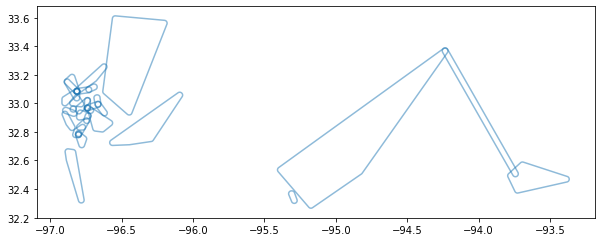

In [33]:
# Convex Hull draws a polygon around the points
# Buffer smooths the corners
# Boundary outlines the polygon
area_poly = areas.convex_hull.buffer(0.02)
area_boundaries = area_poly.boundary
area_boundaries.plot(figsize=(10, 10), alpha=0.5);

In [34]:
area_boundaries.head()

area
1    LINESTRING (-96.72869 32.86642, -96.73001 32.8...
2    LINESTRING (-96.79312 33.03801, -96.79318 33.0...
3    LINESTRING (-96.72098 32.95881, -96.72198 32.9...
4    LINESTRING (-96.60387 32.94422, -96.60280 32.9...
5    LINESTRING (-96.56230 32.70534, -96.56427 32.7...
dtype: geometry

In [35]:
# Export these for manual inspection
area_boundaries.to_file('../data/area_boundaries.shp')

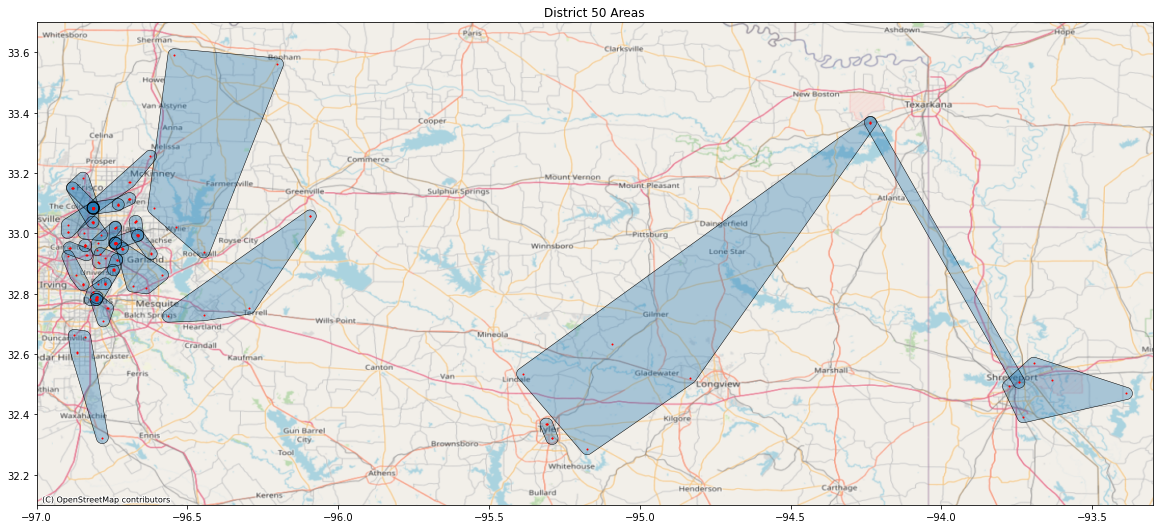

In [36]:
fig, ax = plt.subplots(figsize = (20, 10))
ax.axis(extent)
ax.set_title('District 50 Areas')
ax.plot(g_clubs.long, g_clubs.lat, 'o', markersize=1, color='red')
area_poly.plot(ax=ax, alpha=0.35)
area_boundaries.plot(ax=ax, color='black', linewidth=0.5)
ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.OpenStreetMap.Mapnik)
#plt.savefig('../outputs/20210331_D50_alignment_clubs.png', dpi=1200)
plt.show()

### Manually Check Areas in QGIS
We want to verify there are no obvious adjustments to make. Because the grouping was order-based, we might have situations where one area that is 4 would be better with 5. The following is a screenshot of an area highlighted in QGIS. NOTE: The map above has been rerun with a club adjustment. The screenshot below shows the prior alignment.

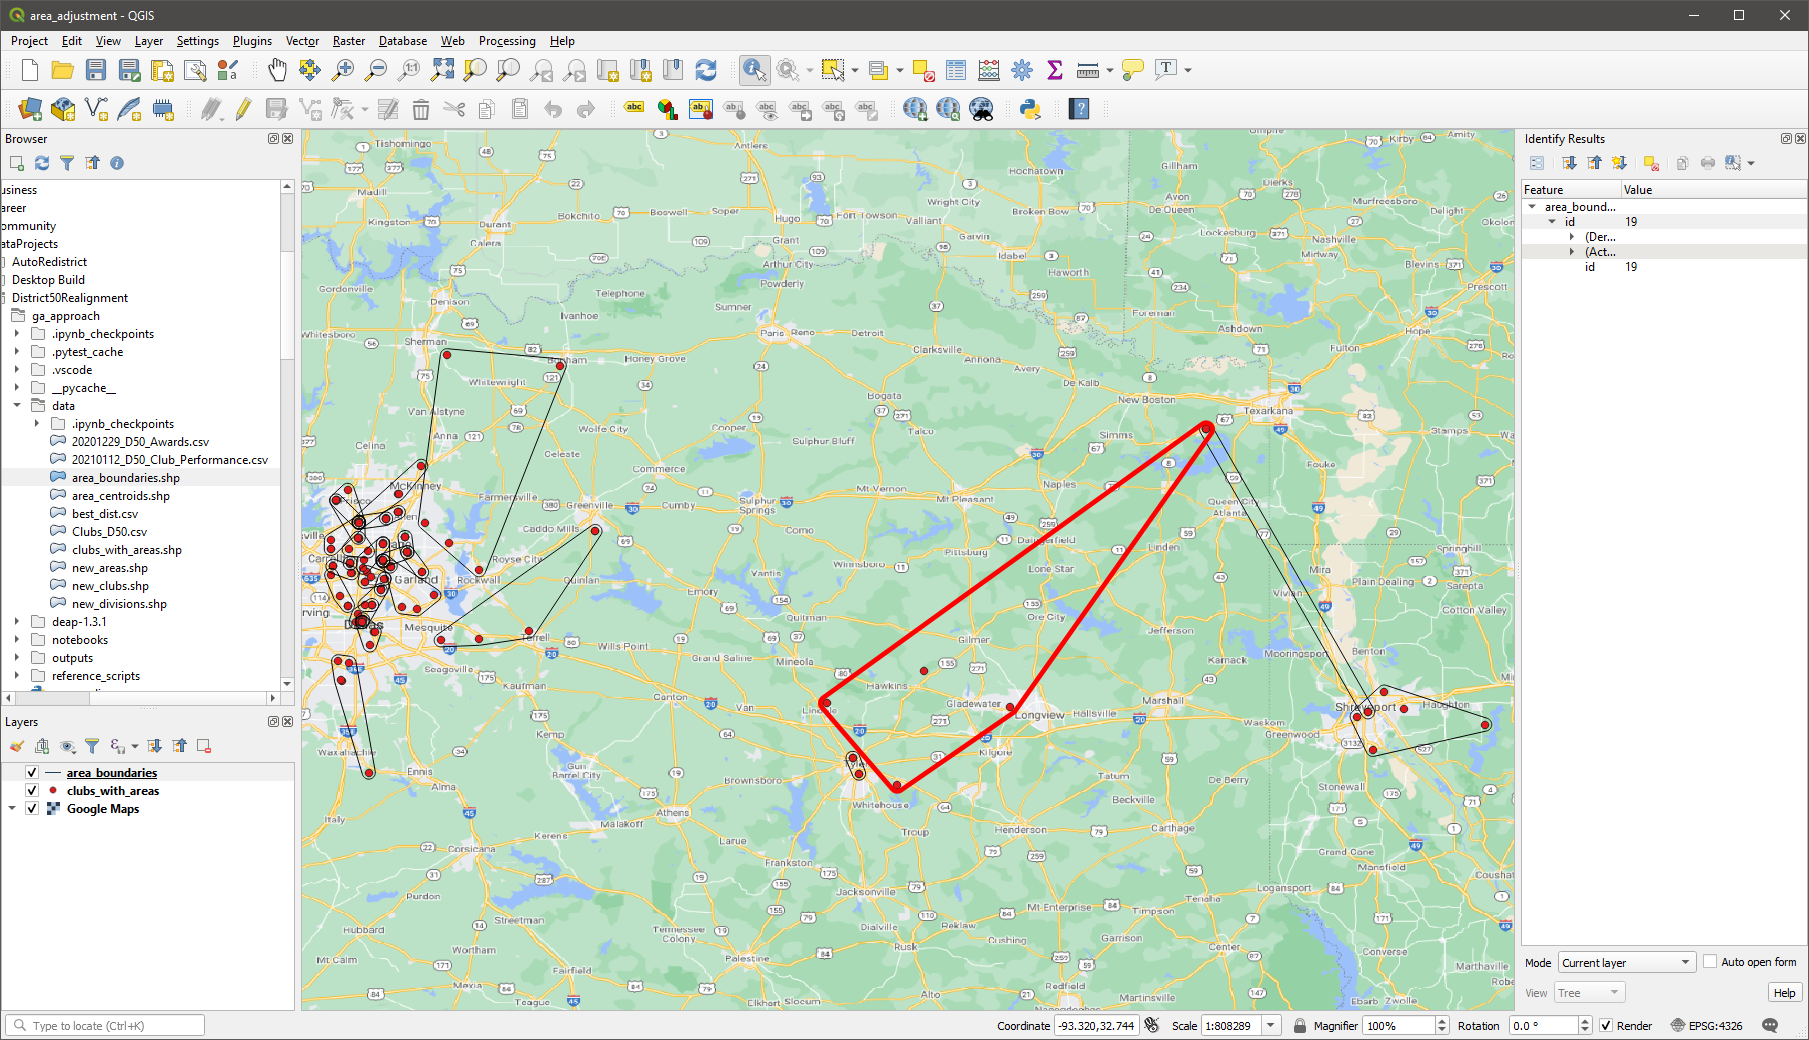

In the Eastern, more sparse part of the map, there is a possible candidate for manual adjustment. Candidates for swapping: Area 19 appears to have 5 clubs from Tyler (4) to Texarkana (1). Area 33 has 4 clubs between Texarkana and Shreveport. The latter has 7 clubs so can't be a single area. Verify the number of clubs in each.

In [37]:
best_dist[best_dist['area'] == 19]

,club_no,n_quality,lat,long,area,geometry
90,2427,0.619137,32.534200,-95.388538,19,POINT (-95.38854 32.53420)
91,5509,0.677709,33.366854,-94.235537,19,POINT (-94.23554 33.36685)
92,1171849,0.442241,32.632143,-95.093099,19,POINT (-95.09310 32.63214)
93,4801055,0.843697,32.521810,-94.832650,19,POINT (-94.83265 32.52181)
94,7031829,0.612749,32.286091,-95.174563,19,POINT (-95.17456 32.28609)


In [38]:
best_dist[best_dist.area == 33]

,club_no,n_quality,lat,long,area,geometry
160,718,0.582775,32.506399,-93.743314,33,POINT (-93.74331 32.50640)
161,7036,0.695792,33.367894,-94.235270,33,POINT (-94.23527 33.36789)
162,9682,0.614715,32.507576,-93.743529,33,POINT (-93.74353 32.50758)
163,1100434,0.768516,33.366908,-94.235278,33,POINT (-94.23528 33.36691)


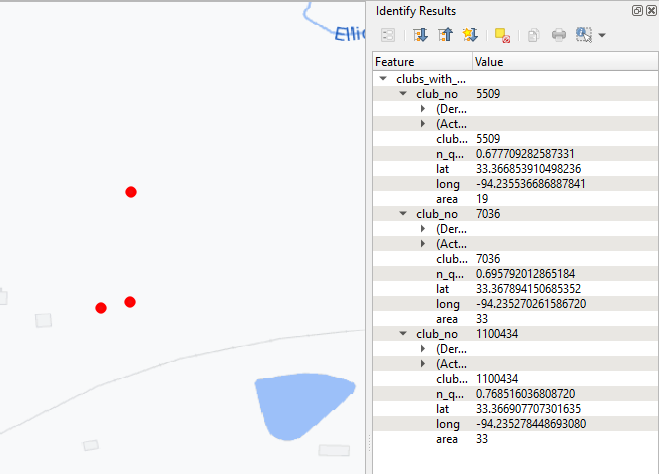

From this selection, we see that indeed, club 5509 could be switched from Area 19 to 33. Check the total distance scores before and after. Set up distances and distance functions. We don't want to use the regular `get_areas` function because that sorts based on the order, not the assigned areas.

In [54]:
with open('../data/dist.pickle', 'rb') as f:  
    dist = pickle.load(f)

def area_distance(area): 
    # Distance between last and first item to initialize
    distance = area.geometry.iloc[-1].distance(area.geometry.iloc[0])
    for i in range(len(area) - 1):
        distance += area.geometry.iloc[i].distance(area.geometry.iloc[i + 1])
    return distance

def area_average_distance(district):
    areas = district.area.unique()
    area_distances = []
    for i in areas:
        clubs = district[district.area == i]
        area_distances.append(area_distance(clubs))
    return np.mean(area_distances)

### Switch Club 5509 to Area 33

In [41]:
# Check the index of that club number
best_dist[best_dist.club_no == 5509]

,club_no,n_quality,lat,long,area,geometry
91,5509,0.677709,33.366854,-94.235537,19,POINT (-94.23554 33.36685)


In [42]:
adj_dist = best_dist.copy()

In [45]:
adj_dist.at[91, 'area'] = 33

In [46]:
adj_dist.iloc[91]

club_no                                              5509
n_quality                                        0.677709
lat                                               33.3669
long                                             -94.2355
area                                                   33
geometry     POINT (-94.23553668688784 33.36685391049824)
Name: 91, dtype: object

In [55]:
print(f'Average distance of result district: {round(area_average_distance(best_dist), 2)}')
print(f'Average distance of adjusted district: {round(area_average_distance(adj_dist), 2)}')

Average distance of result district: 0.54
Average distance of adjusted district: 0.47


### Comments
This indeed took our average distance down from 0.54 to 0.47. Next we need to prep the dataframe for the division grouping genetic algorithm. 

In [56]:
# Create new centroids
area_centroids = best_dist.drop(['club_no', 'n_quality'], axis=1).groupby('area').mean()

In [61]:
g_area_centroids = gpd.GeoDataFrame(area_centroids,
                                    geometry=gpd.points_from_xy(
                                        area_centroids.long, area_centroids.lat),
                                    crs="EPSG:4326")

In [62]:
g_area_centroids.to_file('../data/area_centroids.shp')

In [69]:
area_clubs = pd.DataFrame(adj_dist).drop(['n_quality', 'geometry'], axis=1)

In [70]:
with open('../data/area_clubs.pkl', 'wb') as f:  
    pickle.dump(area_clubs, f)